References:




# 0. Libraries

In [20]:
!pip install timm

In [1]:
import os
import time
from tqdm import tqdm
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, classification_report, roc_auc_score

import skimage
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import models, transforms
import timm

np.random.seed(42)
torch.manual_seed(42)

c:\Users\junxi\anaconda3\envs\msai_nb\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 1. Setup Data Dir and Data class

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Our dataset is structured like this:
# ./data/train/NORMAL
# ./data/train/PNEUMONIA
# ./data/val/NORMAL
# ./data/val/PNEUMONIA
# ./data/test/NORMAL
# ./data/test/PNEUMONIA

# Dont load from drive, it will take very long
data_dir = "./data/"
# drive_data_dir = "/content/drive/MyDrive/2-msai/Health/data"

In [25]:
# data_dir = "/content/data"
# Create local dir
# os.makedirs(data_dir, exist_ok=True)

In [26]:
# Copy data from Google Drive to Colab
# !cp -r {drive_data_dir}/* {data_dir}/

In [4]:
# Define a custom Dataset class
class PneumoniaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Data augmentation to be applied.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Look through folders and get image paths and labels
        # (0 for NORMAL, 1 for PNEUMONIA)
        for label, folder in enumerate(['NORMAL', 'PNEUMONIA']):
            folder_path = os.path.join(self.root_dir, folder)
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                self.image_paths.append(image_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path)

        # Transforms
        if self.transform:
            image = self.transform(image)

        # Get the corresponding label
        label = self.labels[idx]

        return image, label

In [5]:
# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
        transforms.Resize((224, 224)),  # Resize
        transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip
        transforms.RandomRotation(degrees=15),  # Rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
}

In [6]:
# Create datasets
test_dataset = PneumoniaDataset(root_dir=f'{data_dir}/test', transform=data_transforms['test'])

In [7]:
# Create dataset for train and validation
train_dataset = PneumoniaDataset(root_dir=f'{data_dir}/train', transform=data_transforms['train'])
val_dataset = PneumoniaDataset(root_dir=f'{data_dir}/val', transform=data_transforms['val'])

# Combine the datasets
combined_dataset = ConcatDataset([train_dataset, val_dataset])

# Split into new train and validation sets (80:20)
train_indices, val_indices = train_test_split(
    np.arange(len(combined_dataset)),
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Create new dataset split
train_dataset = torch.utils.data.Subset(combined_dataset, train_indices)
val_dataset = torch.utils.data.Subset(combined_dataset, val_indices)

In [8]:
# Create dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=1, shuffle=True),
    'test': DataLoader(test_dataset, batch_size=1, shuffle=True)
}

# 2. Visualization of data

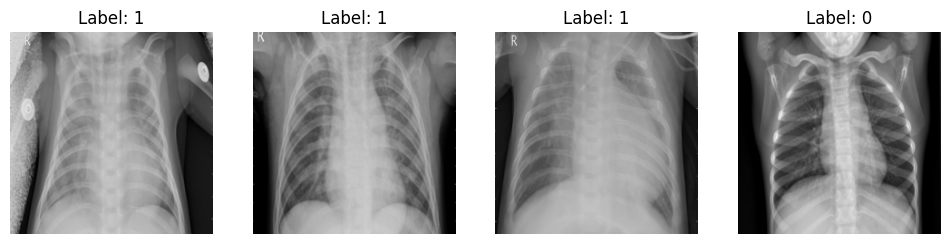

In [44]:
# Function to denormalize the images
def denormalize(img, mean, std):
    """
    Denormalizes image tensor to display the normal images.

    Parameters:
    - img (torch.Tensor): A 3D tensor representing the normalized image. (C, H, W).
    - mean (list): Mean values for each channel (RGB).
    - std (list):Standard deviation values for each channel (RGB).

    Returns:
    - torch.Tensor: Denormalized image tensor.
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = img * std + mean
    return img

# Function to display images along with labels
def show_images(images, labels, mean, std):
    """
    Displays a list of images along with their corresponding labels.

    Parameters:
    - images (list): 3D tensors of images. (C, H, W).
    - labels (list): Labels of each image.
    - mean (list): Mean values for denorm.
    - std (list): Standard deviation values for denorm.
    """
    fig, axes = plt.subplots(1, len(images), figsize=(12, 4))  # Create subplots for each image

    for idx, (img, label) in enumerate(zip(images, labels)):
        img = denormalize(img, mean, std)  # Denorm
        npimg = img.numpy()
        axes[idx].imshow(np.transpose(npimg, (1, 2, 0)))
        axes[idx].set_title(f'Label: {label.item()}')  # Display label
        axes[idx].axis('off')

    plt.show()

# Get 4 images
images, labels = [], []
for i, (image, label) in enumerate(dataloaders['test']):
    if i == 4:
        break
    images.append(image.squeeze(0))
    labels.append(label)

# Display images with labels
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
show_images(images, labels, mean, std)

In [45]:
# Function to display the class distribution for datasets
def display_class_distribution(dataset):
    """
    Prints out class distribution for dataset.

    Parameters:
    - dataset (object): Pytorch dataset object.

    Returns:
    - counter: Class distribution values for the dataset.
    """
    labels = []
    # For torch.utils.data.Subset (New Train and Val)
    if isinstance(dataset, torch.utils.data.Subset):
        original_dataset = dataset.dataset
        if isinstance(original_dataset, torch.utils.data.ConcatDataset):
            for subdataset in original_dataset.datasets:
                labels.extend([subdataset.labels[i] for i in dataset.indices if i < len(subdataset.labels)])
        else:
            labels = [original_dataset.labels[i] for i in dataset.indices]

    # For normal Dataset (Test set)
    elif hasattr(dataset, 'labels'):
        labels = dataset.labels

    # Count class labels
    class_distribution = Counter(labels)
    print("Class Distribution:", class_distribution)

    return class_distribution

# Check the class distribution for the training dataset
print("For training set:")
distribution = display_class_distribution(train_dataset)

print("For validation set:")
distribution = display_class_distribution(val_dataset)

print("For test set:")
distribution = display_class_distribution(test_dataset)

For training set:
Class Distribution: Counter({1: 3126, 0: 1061})
For validation set:
Class Distribution: Counter({1: 757, 0: 288})
For test set:
Class Distribution: Counter({1: 390, 0: 234})


# 3. Training model

In [46]:
# Use pretrained ViT B 16
pretrained_vit = timm.create_model('vit_base_patch16_224', pretrained=True)

# Freeze params
for param in pretrained_vit.parameters():
    param.requires_grad = False

# Add a classification layer on top (We only train this)
pretrained_vit.head = nn.Sequential(
    nn.Linear(pretrained_vit.head.in_features, 128), # Pretrained model output features -> This model's 128 features
    nn.ReLU(inplace=True),
    nn.Linear(128, 2) # Output is 2 for binary classification
).to(device)

In [51]:
# Show model architecture
print(pretrained_vit)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [9]:
# Function to train and val model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, device='cuda'):
    """
    Function to train and validate model.

    Parameters:
    - model (torch.nn.Module): Input model.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - criterion (torch.nn.Module): Loss function for training.
    - optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
    - scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
    - num_epochs (int): Number of epochs for training.
    - device (str): Device to run the model ('cuda' for GPU, 'cpu' for CPU).

    Returns:
    - torch.nn.Module: Best model.
    - list: Training losses.
    - list: Training accuracies.
    - list: Validation losses.
    - list: Validation accuracies.
    """
    # To keep track of training time elapsed
    start = time.time()

    # Move to GPU
    model = model.to(device)

    best_acc = 0.0
    # Lists to store the training and validation metrics
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Train
        model.train()
        trloss = 0.0
        trtruths = 0

        train_progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False)

        for inputs, labels in train_progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Clear grads
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            # Outputs
            _, preds = torch.max(outputs, 1)
            # Loss function
            loss = criterion(outputs, labels)
            # Optimizer step
            loss.backward()
            optimizer.step()

            # Calculate metrics for batch
            trloss += loss.item() * inputs.size(0)
            trtruths += torch.sum(preds == labels.data)

        scheduler.step()

        # Train metrics
        epoch_loss = trloss / len(train_loader.dataset)
        epoch_acc = trtruths.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)  # Store train loss
        train_accuracies.append(epoch_acc.item())  # Store train accuracy
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Val
        model.eval()
        valloss = 0.0
        valtruths = 0
        val_progress_bar = tqdm(val_loader, desc=f"Validating Epoch {epoch + 1}", leave=False)

        with torch.no_grad():
            for inputs, labels in val_progress_bar:
                # Send to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass
                outputs = model(inputs)
                # Outputs
                _, preds = torch.max(outputs, 1)
                # Loss function
                loss = criterion(outputs, labels)
                # Calculate metrics for batch
                valloss += loss.item() * inputs.size(0)
                valtruths += torch.sum(preds == labels.data)

        # Val metrics
        val_loss = valloss / len(val_loader.dataset)
        val_acc = valtruths.double() / len(val_loader.dataset)
        val_losses.append(val_loss)  # Store validation loss
        val_accuracies.append(val_acc.item())  # Store validation accuracy
        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
        print("#" * 10)

    end = time.time() - start
    print(f'Training complete in {end // 60:.0f}m {end % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model
    model.load_state_dict(best_model_wts)

    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [59]:
# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_vit.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [61]:
# Train the model
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(pretrained_vit, dataloaders['train'], dataloaders['val'], criterion, optimizer, scheduler, num_epochs=10, device='cuda')

Epoch 1/10
----------


Train Loss: 0.0805 Acc: 0.9685


Validation Loss: 0.1037 Acc: 0.9589
##########
Epoch 2/10
----------


Train Loss: 0.0736 Acc: 0.9718


Validation Loss: 0.0813 Acc: 0.9637
##########
Epoch 3/10
----------


Train Loss: 0.0836 Acc: 0.9699


Validation Loss: 0.0867 Acc: 0.9656
##########
Epoch 4/10
----------


Train Loss: 0.0736 Acc: 0.9732


Validation Loss: 0.0933 Acc: 0.9637
##########
Epoch 5/10
----------


Train Loss: 0.0806 Acc: 0.9685


Validation Loss: 0.0814 Acc: 0.9713
##########
Epoch 6/10
----------


Train Loss: 0.0771 Acc: 0.9725


Validation Loss: 0.0818 Acc: 0.9637
##########
Epoch 7/10
----------


Train Loss: 0.0768 Acc: 0.9692


Validation Loss: 0.1076 Acc: 0.9542
##########
Epoch 8/10
----------


Train Loss: 0.0790 Acc: 0.9725


Validation Loss: 0.1073 Acc: 0.9542
##########
Epoch 9/10
----------


Train Loss: 0.0741 Acc: 0.9706


Validation Loss: 0.0851 Acc: 0.9637
##########
Epoch 10/10
----------


Train Loss: 0.0749 Acc: 0.9708


Validation Loss: 0.0746 Acc: 0.9723
##########
Training complete in 31m 55s
Best val Acc: 0.9723


In [17]:
# Function to plot training, val loss and acc
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Val Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

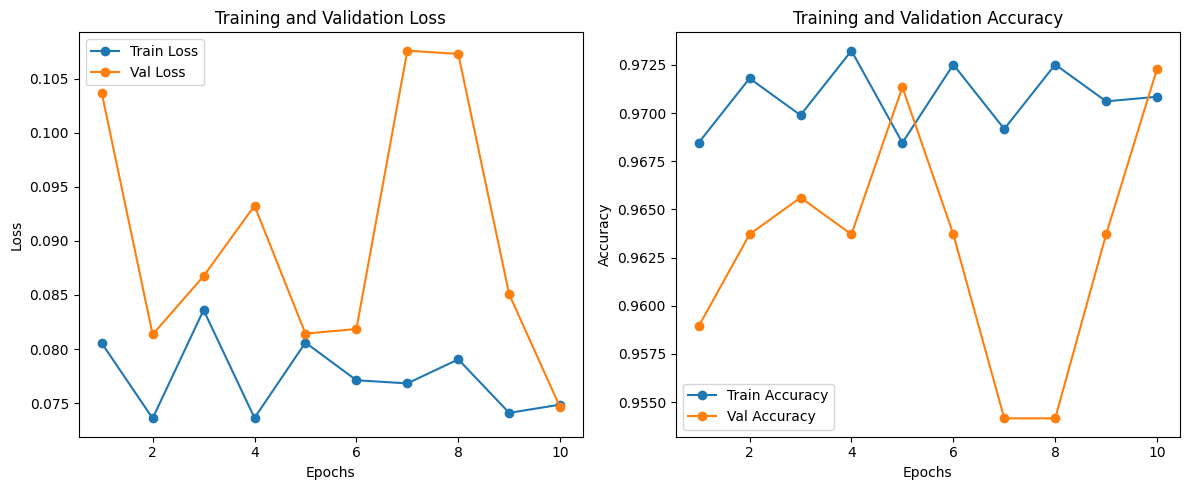

In [63]:
 # Plot the training and validation loss and accuracy
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

# 4. Testing model

In [10]:
def evaluate_model(model, test_loader, criterion, device='cuda'):
    """
    Evaluates the model on the test dataset.

    Parameters:
    - model (torch.nn.Module): Model to be evaluated.
    - test_loader (DataLoader): DataLoader for the test dataset.
    - criterion (torch.nn.Module): Loss function used for evaluation.
    - device (str): ('cuda' for GPU, 'cpu' for CPU).

    Returns:
    - test_loss (float): Loss on the test dataset.
    - test_acc (float): Accuracy on the test dataset.
    - all_labels (numpy.ndarray): True labels.
    - all_preds (numpy.ndarray): Predicted labels.
    - all_probs (numpy.ndarray): Predicted probabilities.
    """
    model.eval()
    testloss = 0.0
    testtruths = 0
    all_preds = []
    all_labels = []
    all_probs = []
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Store predictions and ground truth labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Get probs
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy()[:, 1])  # Assuming class 1 is positive

            # Compute loss
            loss = criterion(outputs, labels)

            # Update metrics
            testloss += loss.item() * inputs.size(0)
            testtruths += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    # Calculate final loss and accuracy
    test_loss = testloss / total_samples
    test_acc = testtruths.double() / total_samples

    return test_loss, test_acc, np.array(all_labels), np.array(all_preds), np.array(all_probs)


In [11]:

def calculate_metrics(all_labels, all_preds, all_probs):
    """
    Calculates metrics for confusion matrix, classification report, and AUC score.

    Parameters:
    - all_labels (numpy.ndarray): True labels of the test dataset.
    - all_preds (numpy.ndarray): Predicted labels.
    - all_probs (numpy.ndarray): Predicted probabilities.

    Returns:
    - cm (numpy.ndarray): Confusion matrix.
    - report (str): Classification report.
    - auc (float or None): AUC.
    """
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Classification Report
    report = classification_report(all_labels, all_preds)

    # AUC
    auc = roc_auc_score(all_labels, all_probs)

    return cm, report, auc


In [12]:
def calculate_metrics2(all_labels, all_preds):
    """
    Calculate metrics: F1, Precision, Recall, Sensitivity, and Specificity.

    Returns:
    - F1 score
    - Precision
    - Recall (Sensitivity)
    - Specificity
    """

    # Precision, Recall, F1 Score
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')  # Sensitivity
    f1 = f1_score(all_labels, all_preds, average='binary')

    # Confusion matrix to compute Specificity
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp)

    return f1, precision, recall, specificity


In [13]:
def plot_confusion_matrix(cm):
    """
    Display Confusion Matrix.

    Parameters:
    - cm (numpy.ndarray): Confusion matrix for matplotlib.
    """
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


In [14]:
def plot_roc_curve(all_labels, all_probs):
    """
    Plots the Receiver Operating Characteristic (ROC) curve.

    Parameters:
    - all_labels (numpy.ndarray): Ground Truth labels of the test dataset.
    - all_probs (numpy.ndarray): Predicted probabilities for the positive class.
    """
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC)')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


In [69]:
# Evaluate model
test_loss, test_acc, all_labels, all_preds, all_probs = evaluate_model(pretrained_vit, dataloaders['test'], criterion, device='cuda')
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 0.3939, Test Acc: 0.8574


# 5. View test results

              precision    recall  f1-score   support

           0       0.93      0.67      0.78       234
           1       0.83      0.97      0.89       390

    accuracy                           0.86       624
   macro avg       0.88      0.82      0.84       624
weighted avg       0.87      0.86      0.85       624



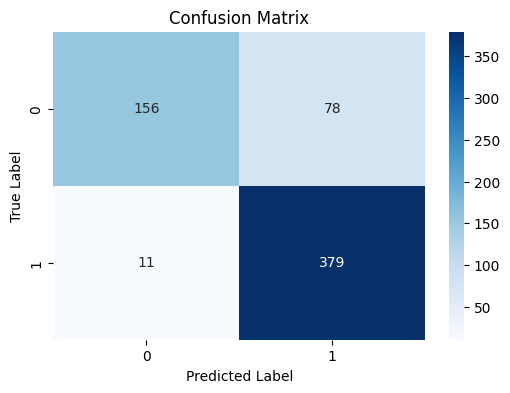

AUC: 0.9616


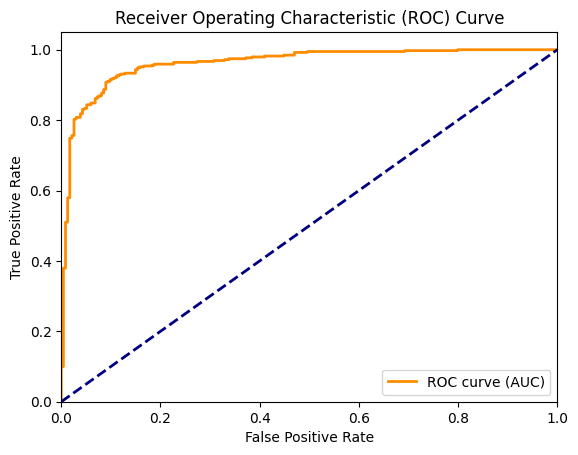

In [70]:
# Calculate and print metrics
cm, report, auc = calculate_metrics(all_labels, all_preds, all_probs)
print(report)

# Plot confusion matrix
plot_confusion_matrix(cm)

# If binary classification, plot ROC curve
if auc is not None:
    print(f'AUC: {auc:.4f}')
    plot_roc_curve(all_labels, all_probs)

In [71]:
# Calculate metrics
f1, precision, recall, specificity = calculate_metrics2(all_labels, all_preds)
print(f'F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall (Sensitivity): {recall:.4f}, Specificity: {specificity:.4f}')

F1 Score: 0.8949, Precision: 0.8293, Recall (Sensitivity): 0.9718, Specificity: 0.6667


# 6. Try out comparison with Resnet50

In [15]:
# Load a pretrained ResNet50 model
pretrained_resnet = models.resnet50(pretrained=True)

# Freeze the parameters
for param in pretrained_resnet.parameters():
    param.requires_grad = False

# Modify the fully connected (fc) layer to match the binary classification
pretrained_resnet.fc = nn.Sequential(
    nn.Linear(pretrained_resnet.fc.in_features, 128),  # ResNet50 outputs 2048 features, reduce to 128
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)  # Final layer for binary classification (2 classes)
)

# Print the final model
print(pretrained_resnet)


c:\Users\junxi\anaconda3\envs\msai_nb\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\junxi\anaconda3\envs\msai_nb\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\junxi/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 116MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(pretrained_resnet, dataloaders['train'], dataloaders['val'], criterion, optimizer, scheduler, num_epochs=10, device='cuda')

Epoch 1/10
----------


Train Loss: 0.5034 Acc: 0.7539


Validation Loss: 0.4060 Acc: 0.7822
##########
Epoch 2/10
----------


Train Loss: 0.4021 Acc: 0.8210


Validation Loss: 0.3195 Acc: 0.8720
##########
Epoch 3/10
----------


Train Loss: 0.3488 Acc: 0.8507


Validation Loss: 0.2810 Acc: 0.8978
##########
Epoch 4/10
----------


Train Loss: 0.3158 Acc: 0.8693


Validation Loss: 0.2506 Acc: 0.8978
##########
Epoch 5/10
----------


Train Loss: 0.3123 Acc: 0.8688


Validation Loss: 0.2147 Acc: 0.9322
##########
Epoch 6/10
----------


Train Loss: 0.2989 Acc: 0.8772


Validation Loss: 0.2198 Acc: 0.9188
##########
Epoch 7/10
----------


Train Loss: 0.2942 Acc: 0.8803


Validation Loss: 0.2034 Acc: 0.9379
##########
Epoch 8/10
----------


Train Loss: 0.2787 Acc: 0.8858


Validation Loss: 0.1936 Acc: 0.9303
##########
Epoch 9/10
----------


Train Loss: 0.2826 Acc: 0.8827


Validation Loss: 0.1931 Acc: 0.9188
##########
Epoch 10/10
----------


Train Loss: 0.2775 Acc: 0.8824


Validation Loss: 0.1853 Acc: 0.9370
##########
Training complete in 52m 18s
Best val Acc: 0.9379


NameError: name 'plot_metrics' is not defined

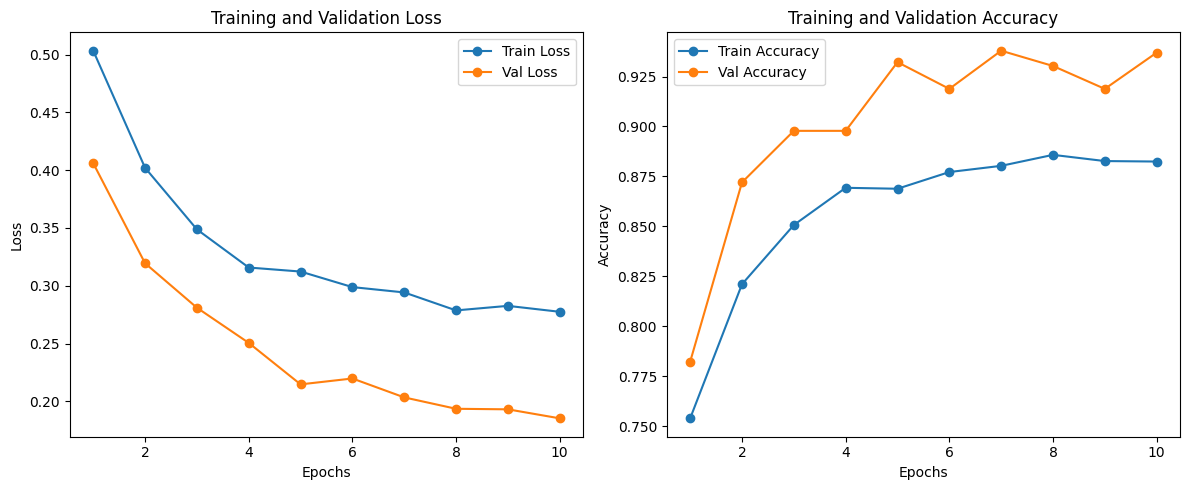

Test Loss: 0.4008, Test Acc: 0.8269
              precision    recall  f1-score   support

           0       0.90      0.61      0.72       234
           1       0.80      0.96      0.87       390

    accuracy                           0.83       624
   macro avg       0.85      0.78      0.80       624
weighted avg       0.84      0.83      0.82       624



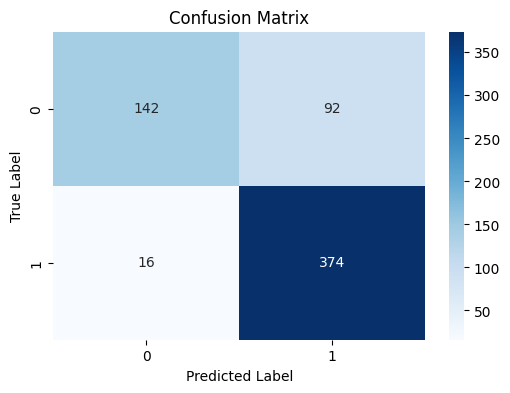

AUC: 0.9230


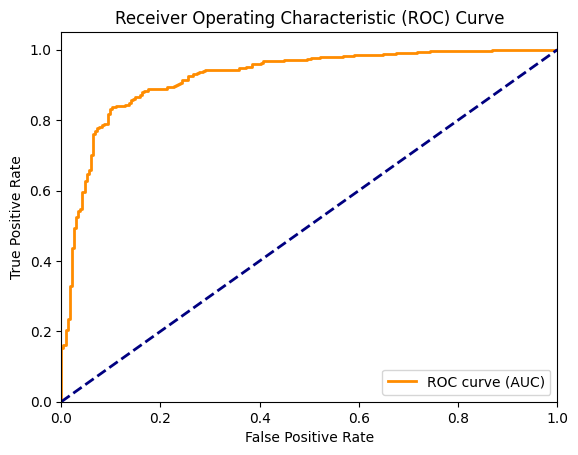

In [19]:

 # Plot the training and validation loss and accuracy
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate model test
test_loss, test_acc, all_labels, all_preds, all_probs = evaluate_model(pretrained_resnet, dataloaders['test'], criterion, device='cuda')
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Calculate and print metrics
cm, report, auc = calculate_metrics(all_labels, all_preds, all_probs)
print(report)

# Plot confusion matrix
plot_confusion_matrix(cm)

# AUX
print(f'AUC: {auc:.4f}')
plot_roc_curve(all_labels, all_probs)